<a href="https://colab.research.google.com/github/tirthasheshpatel/Generative-Models/blob/gans/TransferLearningUsingKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
cd /content
FILES=`ls -a`
flag=0
for FILE in $FILES
do
    if [[ $FILE == "Generative-Models" ]]
    then
        cd $FILE
        branch=`git rev-parse --abbrev-ref HEAD`
        if [[ $branch == "gans" ]]
        then
            git pull origin $branch
        else
            git checkout gans
            git pull origin gans
        fi
        flag=1
        break
    fi
done

if [[ flag -ne 1 ]]
then
    git clone https://github.com/tirthasheshpatel/Generative-Models.git
    cd "Generative-Models"
    git checkout -b gans
    git pull origin gans
fi

From https://github.com/tirthasheshpatel/Generative-Models
 * branch            gans       -> FETCH_HEAD
Already up to date.


In [2]:
%cd /content/Generative-Models/
%tensorflow_version 1.x
import os
import tarfile

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
import cv2
import gan_utils.download_utils as download_utils
import gan_utils.tqdm_utils as tqdm_utils
import gan_utils.keras_utils as keras_utils
%matplotlib inline
print(tf.__version__)
print(keras.__version__)

/content/Generative-Models
TensorFlow 1.x selected.
1.15.2
2.3.1


Using TensorFlow backend.


In [3]:
download_utils.download_flowers_dataset("/content/Generative-Models/data/")

**************************************************
102flowers.tgz
**************************************************
imagelabels.mat


In [4]:
!cd data && ls -a

.  ..  102flowers.tgz  imagelabels.mat


In [0]:
IMG_SIZE = 250

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    h, w, c = img.shape
    h_crop = min(h,w)
    cropped_img = img[(h//2-h_crop//2):(h//2+h_crop//2), (w//2-h_crop//2):(w//2+h_crop//2), :]### YOUR CODE HERE

    # checks for errors
    assert cropped_img.shape == (min(h, w), min(h, w), c), "error in image_center_crop!"

    return cropped_img

def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 671, 3)


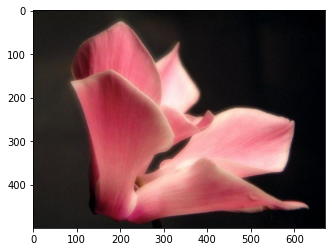

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(250, 250, 3)


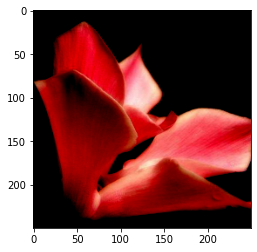

In [84]:
# test cropping
raw_bytes = read_raw_from_tar("data/102flowers.tgz", "jpg/image_00496.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True)
print(img.shape)
plt.imshow(img)
plt.show()

In [17]:
# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames("data/102flowers.tgz"))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat('data/imagelabels.mat')['labels'][0] - 1  # read class labels (0, 1, 2, ...)
# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [0]:
tr_files, te_files, tr_labels, te_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [0]:
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [0]:
# batch generator
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    batch = []
    i = 0
    for item in items:
        batch.append(item)
        i = i + 1
        if i == batch_size:
            i = 0
            yield batch
            batch = []
    yield batch

def train_generator(files, labels):
    while True:
        for batch in batch_generator(raw_generator_with_label_from_tar("data/102flowers.tgz", files, labels), BATCH_SIZE):
            batch_images = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_images.append(img)
                batch_targets.append(label)

            batch_images = np.stack(batch_images, axis=0)
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_images, batch_targets

(32, 250, 250, 3) (32, 102)


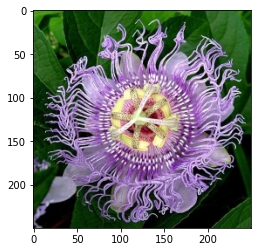

In [0]:
# for _ in train_generator(tr_files, tr_labels):
#     print(_[0].shape, _[1].shape)
#     plt.imshow(np.clip(_[0][0] / 2. + 0.5, 0, 1))
#     break

In [0]:
# list(map(lambda x: len(x), batch_generator(_test_items_generator(), 3)))

In [101]:
s = keras_utils.reset_tf_session()

In [0]:
def inception():
    model = keras.applications.InceptionV3(include_top=False,
                                           input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                           weights='imagenet')
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [103]:
model = inception()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


87916544/87910968 [==============================] - 3s 0us/step


In [0]:
model.summary()

In [106]:
len(model.layers)

313

In [0]:
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.momentum = 0.9

for layer in model.layers[:-50]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adamax(lr=0.001),
    metrics=['accuracy']
)

In [0]:
model_filename = 'flowers.{0:03d}.hdf5'
last_finished_epoch = None

In [112]:
model.fit_generator(
    train_generator(tr_files, tr_labels),
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs = 2*8,
    validation_data=train_generator(te_files, te_labels),
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[keras_utils.TqdmProgressCallback(),
               keras_utils.ModelSaveCallback(model_filename)],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)


Epoch 1/16
**************************
loss: 3.3429; accuracy: 0.2321; val_loss: 5.1075; val_accuracy: 0.2370
Model saved in flowers.000.hdf5

Epoch 2/16
**************************
loss: 1.8845; accuracy: 0.5842; val_loss: 3.3898; val_accuracy: 0.4688
Model saved in flowers.001.hdf5

Epoch 3/16
**************************
loss: 1.0958; accuracy: 0.7310; val_loss: 1.5927; val_accuracy: 0.7240
Model saved in flowers.002.hdf5

Epoch 4/16
**************************
loss: 0.8428; accuracy: 0.7959; val_loss: 0.3823; val_accuracy: 0.7630
Model saved in flowers.003.hdf5

Epoch 5/16
**************************
loss: 0.6288; accuracy: 0.8544; val_loss: 1.1726; val_accuracy: 0.8436
Model saved in flowers.004.hdf5

Epoch 6/16
**************************
loss: 0.6079; accuracy: 0.8613; val_loss: 0.7605; val_accuracy: 0.9115
Model saved in flowers.005.hdf5

Epoch 7/16
**************************
loss: 0.5137; accuracy: 0.8760; val_loss: 0.2946; val_accuracy: 0.9271
Model saved in flowers.006.hdf5

Epoch

In [113]:
model.evaluate_generator(
    train_generator(te_files, te_labels),
    steps=len(te_files) // BATCH_SIZE // 2,
)

[0.12456805258989334, 0.9350000023841858]